### Salish Sea Oil Spill Scenarios

This notebook describes oil particle tracking for spill scenarios in the Salish Sea developed in conjunction with the Canadian Department of Fisheries and Oceans (DFO). The code is for translating particle tracking from *ocean parcels* using the *Salish Sea Cast* grid into input forcing files for *Atlantis* and resulting in oil dispersal on the *Salish Sea Atlantis Model* box grid.

In [1]:
import sys
import os
import math
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from shapely.geometry import Point
from pathlib import Path
from pprint import pprint
from parcels import AdvectionRK4, VectorField, Variable
from parcels import FieldSet, plotTrajectoriesFile, Variable, ScipyParticle, Field
import numpy as np
from datetime import timedelta
sys.path.append('/ocean/rlovindeer/Atlantis/ssam_oceanparcels/Parcels_Utils/particle_tracking/parcels/')
from util.seed_particles import get_particles, get_release_times

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_13ec2871-5eb7-46b7-99ff-51c84aba3f97.so


In [2]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",}
print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 6a_VancouverHarbour_BunkerC


## Creating particle movement through Ocean Parcels

In [3]:
#Kernels
def WindAdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
     Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        wp = fieldset.wind_percentage ## this need to be add to the fieldset
        
        if wp > 0:

            (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
            u1 = u1 * wp
            v1 = v1 * wp
            lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
            
            (u2, v2) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat1, lon1]
            u2 = u2 * wp
            v2 = v2 * wp
            lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
            
            (u3, v3) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat2, lon2]
            u3 = u3 * wp
            v3 = v3 * wp
            lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
            
            (u4, v4) = fieldset.UVwind[time + particle.dt, particle.depth, lat3, lon3]
            u4 = u4 * wp
            v4 = v4 * wp            
            
            u_wind  = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            v_wind  = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.beached = 2
            
def BeachTesting(particle, fieldset, time):
    """ Testing if particles are on land. if 'yes' particle will be removed"""
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        #print(u, v)
        if u == 0 and v == 0:
            particle.beached = 1
        else:
            particle.beached = 0

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def DecayParticle(particle, fieldset, time):
    dt = particle.dt
    field_decay_value = fieldset.decay
    decay = math.exp(-1.0 * dt/field_decay_value)
    particle.decay_value = particle.decay_value * decay

In [4]:
# Data Paths
currents = Path('/ocean/rlovindeer/Atlantis/Physics/Raw_Transport_Data/')
winds = Path('/ocean/rlovindeer/Atlantis/Physics/Wind/')
sea_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc')
air_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc')

In [5]:
# Salish Sea NEMO Model Grid, Geo-location and Bathymetry, v17-02

# Currents
u_current = sorted([p for p in currents.glob('2019-01*URaw_variables.nc')])
v_current = sorted([p for p in currents.glob('2019-01*VRaw_variables.nc')])

filenames = {
    'U': {'lon': sea_grid,'lat': sea_grid,'data': u_current},
    'V': {'lon': sea_grid,'lat': sea_grid,'data': v_current}
            }

variables = {'U': 'uVelocity','V': 'vVelocity'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
print('creating from_nemo')
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
print('creating from_nemo done')

fieldset.add_constant('decay', 1.0 * 3600.0)
print('add_constant decay')

creating from_nemo


creating from_nemo done
add_constant decay


In [6]:
# HRDPS, Salish Sea, Atmospheric Forcing Grid, Geo-location, v1"

wind_paths = sorted([p for p in winds.glob('2019-01*Wind_variables.nc')])
wind_filenames = {'lon': os.fspath(air_grid),'lat': os.fspath(air_grid),'data': wind_paths}
wind_dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

pprint(wind_filenames)

{'data': [PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-01-01_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-01-07_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-01-13_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-01-19_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-01-25_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-01-31_Wind_variables.nc')],
 'lat': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc',
 'lon': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc'}


In [7]:
Uwind_field = Field.from_netcdf(wind_filenames, ('U_wind', 'u_wind'),
                                     wind_dimensions,
                                     fieldtype='U',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)
Vwind_field = Field.from_netcdf(wind_filenames, ('V_wind', 'v_wind'),
                                     wind_dimensions,
                                     fieldtype='V',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)

print('wind data loaded')

wind data loaded


In [8]:
# change longitude for the wind field
Uwind_field.grid.lon = Uwind_field.grid.lon - 360
Vwind_field.grid.lon = Vwind_field.grid.lon - 360

[x_min, x_max, y_min, y_max] = Uwind_field.grid.lonlat_minmax

Uwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]
Vwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]

## adding the wind field to the fieldset object
fieldset.add_field(Uwind_field)
fieldset.add_field(Vwind_field)
wind_field = VectorField('UVwind', Uwind_field,  Vwind_field)
fieldset.add_vector_field(wind_field)

In [9]:
# wind_percentage
# We need to do a sensitivity analysis of the percetage of wind to be used here
wind_percentage = 1
fieldset.add_constant('wind_percentage', wind_percentage/100.0)

In [10]:
class MyParticle(ScipyParticle):
    initial_time = -100
    decay_value = Variable('decay_value', dtype=np.float32, initial=1.0)
    beached = Variable('beached', dtype=np.int32, initial=0.)
    age = Variable('age', dtype=np.int32, initial=0.)

# Particle Features
num_particles_per_day = 100
feature_release_index = 0
input_shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/" + scenario[file_id] + ".shp"
release_depth = -0.1
release_start_time = '2019-01-01'  ## winter start on December, Summer Jul - Aug
release_end_time = '2019-01-02'
release_start_time = np.datetime64(release_start_time)
release_end_time = np.datetime64(release_end_time)
time_origin = fieldset.U.grid.time_origin.time_origin

print('setting up particles')

[release_times, p, num_particles] = get_release_times(time_origin, num_particles_per_day, release_start_time, release_end_time)
pset = get_particles(fieldset, num_particles, input_shapefile_name, MyParticle, feature_release_index, release_times, release_depth)

print(pset)

# Building the kernels
decay_kernel = pset.Kernel(DecayParticle)
beaching_kernel = pset.Kernel(BeachTesting)
ForcingWind_kernel = pset.Kernel(WindAdvectionRK4)

# Adding to the main kernel
my_kernel = AdvectionRK4 + decay_kernel + ForcingWind_kernel + beaching_kernel

output_file_name = scenario[file_id] + str(release_start_time) + '_oil_disperse.nc'
print(output_file_name)

setting up particles
-261000.0
100
100
Using shapefile /ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/6a_VancouverHarbour_BunkerC.shp
Number of sites :  1
Up to 0 of 1
81
100
Sucessfully seeded particles

num_attempts = 2
[-123.18123928126776, -123.18057787454389, -123.1810248102041, -123.18125490577394, -123.18173683426343, -123.180853349278, -123.18168144767796, -123.17987588808137, -123.18189669720107, -123.18027361641929, -123.18131846514281, -123.18116283057155, -123.17974142638154, -123.18307464988733, -123.18011104415531, -123.18032755547155, -123.1799623956671, -123.18024406535284, -123.18158646737805, -123.1803181241872, -123.18295083627903, -123.1808770945676, -123.1796656068893, -123.1813464780242, -123.18177258426678, -123.18236931346236, -123.18034315111882, -123.1816076522798, -123.18116128260847, -123.18334632513911, -123.18096568792105, -123.18098771061084, -123.18096847664859, -123.17966926756934, -123.18071052915577, -123.18199184234896, -123.1

In [11]:
try:
    os.system('rm ' + output_file_name)
except:
    pass

print('executing particle kernel')

executing particle kernel


rm: cannot remove '6a_VancouverHarbour_BunkerC2019-01-01_oil_disperse.nc': No such file or directory


INFO: Temporary output files are stored in out-DBJTRUDS.
INFO: You can use "parcels_convert_npydir_to_netcdf out-DBJTRUDS" to convert these to a NetCDF file during the run.
100% (345600.0 of 345600.0) |############| Elapsed Time: 0:04:46 Time:  0:04:46


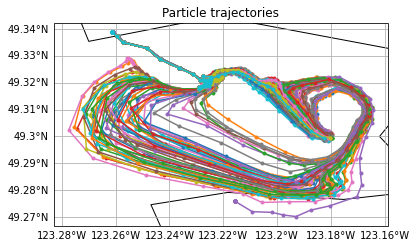

particle trajectories completed


In [12]:
## Output properties
output_file = pset.ParticleFile(name= output_file_name, outputdt = timedelta(minutes = 60))
pset.execute(my_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(hours = 24*4),   # total length of the run
             dt = timedelta(minutes = 60),      # timestep of the kernel
             output_file = output_file)         # file name and the time step of the outputs
output_file.close()

plotTrajectoriesFile(output_file_name);

print('particle trajectories completed')

## Parcing Ocean Parcels output into Atlantis input files


In [13]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)

In [14]:
numLayers = 5;
numSites = data_df.shape[0]
numTargetSites = numSites

outputDT = 60*60 #1 hour

stepsPerDay = int(86400.0/ outputDT);
numStepsPerDT = stepsPerDay;
numStepsPerDT = int(outputDT/3600.0)

debug = False

inputFileName = output_file_name
pfile = xr.open_dataset(str(inputFileName), decode_cf=True)

In [15]:
lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)
z = np.ma.filled(pfile.variables['z'], np.nan)
probs = np.ma.filled(pfile.variables['decay_value'], np.nan)

numParticles = lon.shape[0]

trackDates = [];

for i in range(0,numParticles):
    print(time[i][0])
    trackDates.append(time[i][0])

RDiff = max(trackDates) - min(trackDates)

minDate = np.datetime64("2019-01-01T00:30:00");
ts = pd.to_datetime(str(minDate))
d = ts.strftime('%Y-%m-%d %H:%M:%S')
print(d)

2019-01-01T18:00:00.000000000
2019-01-01T14:00:00.000000000
2019-01-01T09:00:00.000000000
2019-01-01T11:00:00.000000000
2019-01-01T07:00:00.000000000
2019-01-01T00:00:00.000000000
2019-01-01T00:00:00.000000000
2019-01-01T09:00:00.000000000
2019-01-01T13:00:00.000000000
2019-01-01T16:00:00.000000000
2019-01-01T16:00:00.000000000
2019-01-01T10:00:00.000000000
2019-01-01T05:00:00.000000000
2019-01-01T09:00:00.000000000
2019-01-01T22:00:00.000000000
2019-01-01T21:00:00.000000000
2019-01-01T11:00:00.000000000
2019-01-01T08:00:00.000000000
2019-01-01T14:00:00.000000000
2019-01-01T04:00:00.000000000
2019-01-01T05:00:00.000000000
2019-01-01T08:00:00.000000000
2019-01-01T21:00:00.000000000
2019-01-01T06:00:00.000000000
2019-01-01T23:00:00.000000000
2019-01-01T14:00:00.000000000
2019-01-01T19:00:00.000000000
2019-01-01T15:00:00.000000000
2019-01-01T14:00:00.000000000
2019-01-01T05:00:00.000000000
2019-01-01T21:00:00.000000000
2019-01-01T22:00:00.000000000
2019-01-01T01:00:00.000000000
2019-01-01

In [16]:
numReleaseDays = 1;
numReleaseSteps = numReleaseDays * stepsPerDay;
trackLength = len(lon[0]);

print('trackLength = ' + str(trackLength))
print('numStepsPerDT = ' + str(numStepsPerDT))

numSteps = int(trackLength / numStepsPerDT)

trackLength = 97
numStepsPerDT = 1


In [17]:
# Create the netcdf output file for Atlantis

netcdfFileName = "Atlantis_" + scenario[file_id] + str(release_start_time) + str(outputDT) + ".nc"

try:
    os.remove(netcdfFileName)
except:
    pass

ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)

# Dimensions
time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numTargetSites)
z = ncfile.createDimension("z", numLayers)

# Variables
times = ncfile.createVariable("time","f4",("t",))
oil = ncfile.createVariable("oil","f4",("t", "b",))
Naphthalene = ncfile.createVariable("Naphthalene","f4",("t", "b",))
Phenanthrene = ncfile.createVariable("Phenanthrene","f4",("t", "b",))
Pyrene = ncfile.createVariable("Pyrene","f4",("t", "b",))
Benzo = ncfile.createVariable("Benzo","f4",("t", "b",))

# Attributes
times.units = "seconds since " + d
times.dt = str(outputDT);
oil.units = "mgPAH/m^3"
oil.long_name = "Amount of PAH"

Naphthalene.units = "mgPAH/m^3"
Naphthalene.long_name = "Amount of Naphthalene"

Phenanthrene.units = "mgPAH/m^3"
Phenanthrene.long_name = "Amount of Phenanthrene"

Pyrene.units = "mgPAH/m^3"
Pyrene.long_name = "Amount of Pyrene"

Benzo.units = "mgPAH/m^3"
Benzo.long_name = "Amount of Benzo(a)pyrene"

# Populate variables with data
timeData = np.arange(0,(numSteps + numReleaseSteps)*outputDT,outputDT)
times[:] = timeData;

boxDispersal = np.zeros((numSteps + numReleaseSteps, numTargetSites));

In [18]:
for partIndex in range(0, numParticles):

    trackDateDiff = trackDates[partIndex] - minDate;
    trackDateDiff = trackDateDiff/ np.timedelta64(1, 's')

    timeOffset = int(abs((trackDateDiff /outputDT)));

    for stepIndex in range(0, numSteps):
        timeValue = stepIndex + timeOffset

        partLon = lon[partIndex][stepIndex * numStepsPerDT];
        partLat = lat[partIndex][stepIndex * numStepsPerDT];
        partProb = probs[partIndex][stepIndex * numStepsPerDT];

        matchFound = 0;

        for targetIndex in range(0, numTargetSites):

            path = data_df.iloc[targetIndex].geometry
            checks = path.contains(Point(partLon, partLat));

            if checks:
                boxDispersal[timeValue][targetIndex] = boxDispersal[timeValue][targetIndex] + partProb;

                # uncomment line below to ignore particle decay during debugging.
                #boxDispersal[timeValue][targetIndex] = boxDispersal[timeValue][targetIndex] + 1.0

                matchFound = 1
                if debug:
                    print('At time ' + str(timeValue) + ' Particle (' + str(partIndex) + ') in box ' + str(data_df.iloc[targetIndex].BOX_ID))


                break;

        if matchFound == 0:
            if debug:
                print('No match for particle')
                print(partLon, partLat)


        #break

oil[:, :] = boxDispersal;
Naphthalene[:, :] = boxDispersal;
Phenanthrene[:, :] = boxDispersal;
Pyrene[:, :] = boxDispersal;
Benzo[:, :] = boxDispersal;

ncfile.close()

## Animating Oil Dispersal Scenario in the Salish Sea Atlantis Model

In [19]:
boxes = data_df['BOTZ']
land_boxes = boxes==0
land_boxes = data_df.index[land_boxes]

numReleaseDays = RDiff
print('numReleaseDays = ' + str(numReleaseDays))

numReleaseDTS = int(abs(numReleaseDays/np.timedelta64(1, 'h')));
totalNumOfTS = int(numReleaseDTS + trackLength);
print('totalNumOfTS = ' + str(totalNumOfTS))
print('trackLength = ' + str(trackLength))
print(numParticles)

numReleaseDays = 82800000000000 nanoseconds
totalNumOfTS = 120
trackLength = 97
100


In [20]:
trackLonsPadded = np.zeros((int(numParticles), totalNumOfTS));
trackLatsPadded = np.zeros((int(numParticles), totalNumOfTS));
particlesAge = np.zeros((int(numParticles), totalNumOfTS));

for trackIndex in range(0,numParticles):

    print(trackDates[trackIndex])
    print(minDate)
    trackDateDiff = trackDates[trackIndex] - minDate

    print(trackDateDiff/np.timedelta64(1, 'h'))

    trackNumsToPad = int(trackDateDiff/np.timedelta64(1, 'h'))
    print(trackNumsToPad)

    trackLonsPadded[trackIndex][0:trackNumsToPad] = 0;
    trackLatsPadded[trackIndex][0:trackNumsToPad] = 0;

    trackLonsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lon[:][trackIndex];
    trackLatsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lat[:][trackIndex];

numSteps = int(trackLength / numStepsPerDT)

2019-01-01T18:00:00.000000000
2019-01-01T00:30:00
17.5
17
2019-01-01T14:00:00.000000000
2019-01-01T00:30:00
13.5
13
2019-01-01T09:00:00.000000000
2019-01-01T00:30:00
8.5
8
2019-01-01T11:00:00.000000000
2019-01-01T00:30:00
10.5
10
2019-01-01T07:00:00.000000000
2019-01-01T00:30:00
6.5
6
2019-01-01T00:00:00.000000000
2019-01-01T00:30:00
-0.5
0
2019-01-01T00:00:00.000000000
2019-01-01T00:30:00
-0.5
0
2019-01-01T09:00:00.000000000
2019-01-01T00:30:00
8.5
8
2019-01-01T13:00:00.000000000
2019-01-01T00:30:00
12.5
12
2019-01-01T16:00:00.000000000
2019-01-01T00:30:00
15.5
15
2019-01-01T16:00:00.000000000
2019-01-01T00:30:00
15.5
15
2019-01-01T10:00:00.000000000
2019-01-01T00:30:00
9.5
9
2019-01-01T05:00:00.000000000
2019-01-01T00:30:00
4.5
4
2019-01-01T09:00:00.000000000
2019-01-01T00:30:00
8.5
8
2019-01-01T22:00:00.000000000
2019-01-01T00:30:00
21.5
21
2019-01-01T21:00:00.000000000
2019-01-01T00:30:00
20.5
20
2019-01-01T11:00:00.000000000
2019-01-01T00:30:00
10.5
10
2019-01-01T08:00:00.00000000

In [21]:
savefile_prefix = 'boxes'

pfile = xr.open_dataset(str(netcdfFileName), decode_cf=True)

print(pfile)

time = np.ma.filled(pfile.variables['time'], np.nan)

oil = np.ma.filled(pfile.variables['Benzo'], np.nan)
num_steps = time.shape[0]
print(num_steps)

<xarray.Dataset>
Dimensions:       (t: 121, b: 130)
Dimensions without coordinates: t, b
Data variables:
    time          (t) datetime64[ns] ...
    oil           (t, b) float32 ...
    Naphthalene   (t, b) float32 ...
    Phenanthrene  (t, b) float32 ...
    Pyrene        (t, b) float32 ...
    Benzo         (t, b) float32 ...
121


In [22]:
v_max = 80
_cmap = cm.viridis
file_names = []

land_df = data_df.loc[land_boxes]

for time_index in range(0, num_steps):

    plon = trackLonsPadded[:, time_index]
    plat = trackLatsPadded[:, time_index]

    plon = plon[plon<0]
    plat = plat[plat>0]
    time_oil = oil[time_index]

    data_df['oil'] = time_oil
    data_df.loc[land_boxes, 'oil'] = 10000

    ax = data_df.plot(figsize=(15, 15), column = 'oil', cmap = _cmap, vmin=0, vmax=v_max, legend=True)
    land_df.plot(ax=ax, color='gray')
    ax.scatter(plon, plat, s=10, color='red', zorder=20)

    ax.set_title(time[time_index])

    plot_name = savefile_prefix + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

IndexError: index 120 is out of bounds for axis 1 with size 120

In [23]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into loop
frames[0].save('Oil_Scenario_' + scenario[file_id]+ '.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)


In [24]:
file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

0

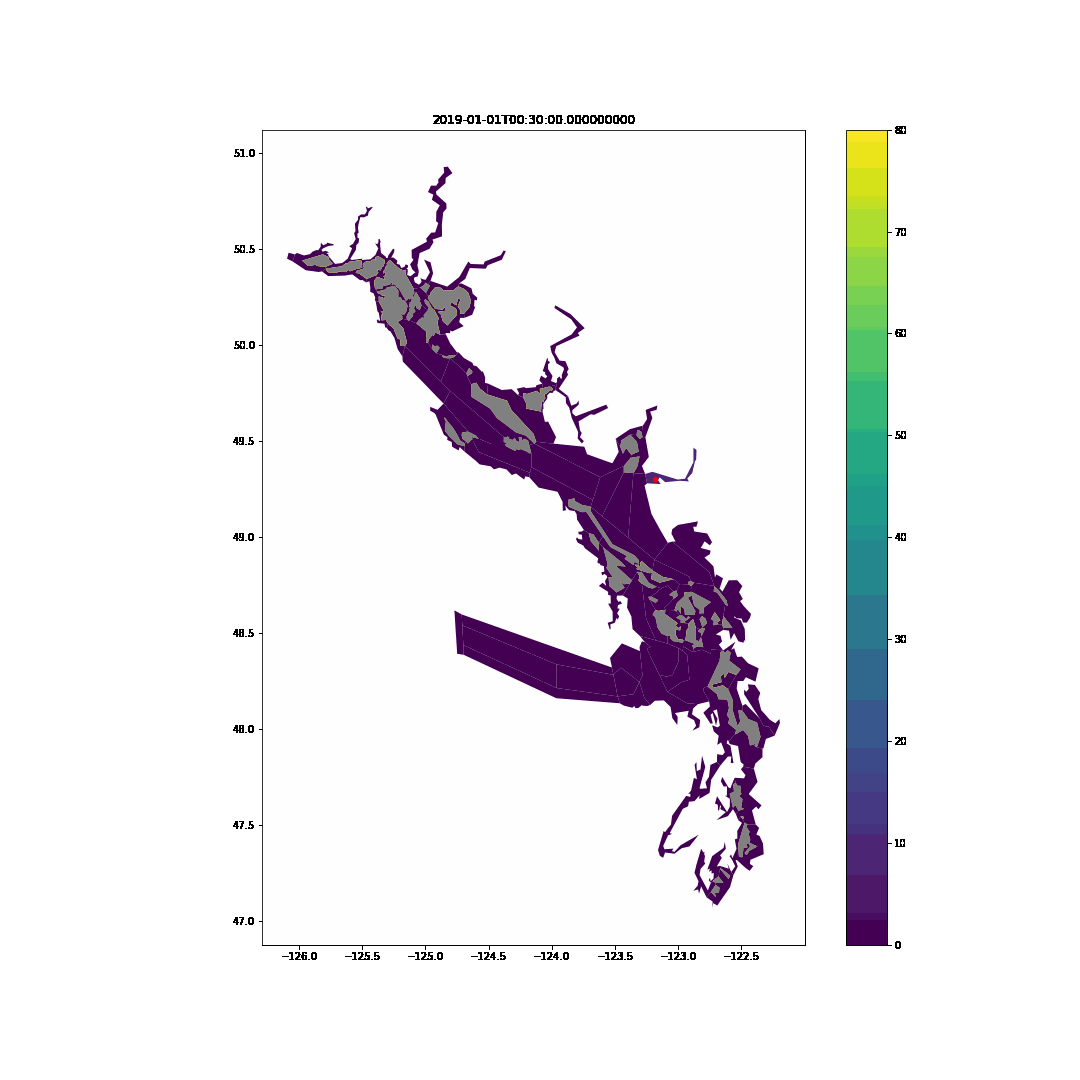

In [25]:
from IPython.display import Image
Image(filename='Oil_Scenario_' + scenario[file_id]+ '.gif') 